 # Data Science Capstone Project
 
 ## Part 1, Importing Data and Understaning the Business Problem
     The data we are using was provided by user Mirbek Toktogaraev on Kaggle, its description is as follows:
     
    The dataset is from the U.S. Small Business Administration (SBA)
    The U.S. SBA was founded in 1953 on the principle of promoting and assisting small enterprises in the U.S. credit market (SBA Overview and History, US Small Business Administration (2015)). Small businesses have been a primary source of job creation in the United States; therefore, fostering small business formation and growth has social benefits by creating job opportunities and reducing unemployment.
   
    For this capstone, I chose this specific data set because I envisioned running analysis to see if we could predict which small businesses would be successful, are there factors that help discover this? However, before formally stating this, I would like to do some light exploration on the dataset to ensure it is the correct path to take.
    
    The features and their descriptions can be found at: https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied

In [56]:
import types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3
import seaborn as sns
import matplotlib.pyplot as pl
import sklearn as sk
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.ensemble import RandomForestClassifier

from time import time


In [57]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_35fd6d9c8a7d43ee96101400fb522263 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='XrnnGmYfXFDcqD6QckIGRZBjWQTg1h3QpektDmsgK5Xi',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_35fd6d9c8a7d43ee96101400fb522263.get_object(Bucket='udacityfinal-donotdelete-pr-bekjcfcndzlfhi',Key='SBAnational.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [58]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [59]:
#ChgOffDate is the date a loan is declared to be in default, so we can see if there is a default by using this column
print('Number of Nondefaulted Loans:', df['ChgOffDate'].isnull().sum() )
print('Number of Defaulted Loans:', df.shape[0] - df['ChgOffDate'].isnull().sum() )

Number of Nondefaulted Loans: 736465
Number of Defaulted Loans: 162699


 We can see that there is substainal data to support our analysis. Roughly one-eighth of the data could be considered default, while the other slice of it would be non defaulted. 
 
 This allows us to formally propose our business problem: **Can we use a classification algorithm to predict whether or not a small business loan will default, and what features will be key to analysis?**

 ## Part 2, Data Engineering, Maniplation and Preparation
 
     We will now proceed to the act of exploring the data; we need to know what we have, what values would work with a classification algorithm, and whether or not we should keep every column. For first thoughts, I immediately think of the *ChgOffDate* column which will have to be rendered into dummy variables, as having NaN v. specific dates of default will be a problem. It also occurs to me that several columns are related directly to defaulting like *ChgOffPrinGr*, which essential would posion the well. All of these columns related to defaulting need to be purged as each serves and interchangable purpose for the analysis we are proceeding with.

In [60]:
#assessment of missing data
miss_data =df.isnull().sum()
print(miss_data)

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64


In [61]:
#We can see that ChgOffDate is the only set with null values that we would like to keep. Let's then convert it to "dummy values" before we then 
#drop all of the remaining null values
target = df['ChgOffDate']
df_drop = df.drop(columns = ['ChgOffDate'])
print(df_drop.columns)

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'DisbursementDate', 'DisbursementGross', 'BalanceGross',
       'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')


In [62]:
#Now we convert NaN in our target to 0, with the other values to 1
target = target.fillna(0)

In [63]:
target.loc[target != 0] = 1
target

0         0
1         0
2         0
3         0
4         0
5         0
6         1
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
899134    0
899135    0
899136    0
899137    0
899138    1
899139    0
899140    0
899141    0
899142    0
899143    1
899144    0
899145    0
899146    0
899147    0
899148    0
899149    0
899150    0
899151    0
899152    0
899153    1
899154    0
899155    0
899156    0
899157    0
899158    0
899159    0
899160    0
899161    0
899162    1
899163    0
Name: ChgOffDate, Length: 899164, dtype: int64

In [64]:
#add target back
df_new = pd.concat([df_drop, target], axis=1)
df_new.head(7)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,ChgOffDate
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00",0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00",0
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,...,N,N,30-Jun-97,"$517,000.00",$0.00,P I F,$0.00,"$517,000.00","$387,750.00",0
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,2-Jun-80,1980,...,N,N,22-Jul-80,"$600,000.00",$0.00,CHGOFF,"$208,959.00","$600,000.00","$499,998.00",1


In [65]:
df_new = df_new.dropna()
print(df_new.isnull().sum())
print(df_new.shape)

LoanNr_ChkDgt        0
Name                 0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
ChgOffDate           0
dtype: int64
(886240, 27)


In [66]:
#Now that we have our target variable cleaned up, it comes time to drop columns that have a one to one corelation to our target, let's observe
df_new.head(10)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,ChgOffDate
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00",0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00",0
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,...,N,N,30-Jun-97,"$517,000.00",$0.00,P I F,$0.00,"$517,000.00","$387,750.00",0
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,2-Jun-80,1980,...,N,N,22-Jul-80,"$600,000.00",$0.00,CHGOFF,"$208,959.00","$600,000.00","$499,998.00",1
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,28-Feb-97,1997,...,N,Y,30-Jun-98,"$45,000.00",$0.00,P I F,$0.00,"$45,000.00","$36,000.00",0
8,1000104006,TURTLE BEACH INN,PORT SAINT JOE,FL,32456,CENTENNIAL BANK,FL,721310,28-Feb-97,1997,...,N,N,31-Jul-97,"$305,000.00",$0.00,P I F,$0.00,"$305,000.00","$228,750.00",0
9,1000124001,INTEXT BUILDING SYS LLC,GLASTONBURY,CT,6073,WEBSTER BANK NATL ASSOC,CT,0,28-Feb-97,1997,...,N,Y,30-Apr-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00",0


In [67]:
#Immediately MIS_Status and the other Chg Off stick out. Let's get rid of them and then look at the data types we have
df_new.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
ChgOffDate             int64
dtype: object

We need to be aware that any object columns will need to be turned into dummy values, so the less we have the better as to not overcomplicate the model. There are also several objects it would be smart to rid ourselves of, such as name (a superflous idenifier with LoanNr_ChkDgt), and city. Additionally, based on the number of factors needed for a dummy variable we will remove certain columns (bank, dates)

One thing to note here that could be done for improvement is feature scaling, however, for the sake of time we will abstain from this, but based on our ultimate accuracy score this could be a way to improve our model.
Another is the Date could be translated into Season, year or a number of different factors to make it more usable, but once more for times sake we will simply mention this rather than implement it.

In [68]:
#1st round of drops
df_new = df_new.drop(columns = ['MIS_Status'])
df_new = df_new.drop(columns = ['ChgOffPrinGr'])
df_new = df_new.drop(columns = ['DisbursementDate'])
df_new = df_new.drop(columns = ['ApprovalDate'])
df_new = df_new.drop(columns = ['Bank'])
df_new = df_new.drop(columns = ['City'])
df_new.head()

,LoanNr_ChkDgt,Name,State,Zip,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,...,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,ChgOffDate
0,1000014003,ABC HOBBYCRAFT,IN,47711,OH,451120,1997,84,4,2.0,...,0,1,0,N,Y,"$60,000.00",$0.00,"$60,000.00","$48,000.00",0
1,1000024006,LANDMARK BAR & GRILLE (THE),IN,46526,IN,722410,1997,60,2,2.0,...,0,1,0,N,Y,"$40,000.00",$0.00,"$40,000.00","$32,000.00",0
2,1000034009,"WHITLOCK DDS, TODD M.",IN,47401,IN,621210,1997,180,7,1.0,...,0,1,0,N,N,"$287,000.00",$0.00,"$287,000.00","$215,250.00",0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",OK,74012,OK,0,1997,60,2,1.0,...,0,1,0,N,Y,"$35,000.00",$0.00,"$35,000.00","$28,000.00",0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",FL,32801,FL,0,1997,240,14,1.0,...,7,1,0,N,N,"$229,000.00",$0.00,"$229,000.00","$229,000.00",0


In [69]:
df_new = df_new.drop(columns = ['Name'])
df_new.dtypes


LoanNr_ChkDgt          int64
State                 object
Zip                    int64
BankState             object
NAICS                  int64
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementGross     object
BalanceGross          object
GrAppv                object
SBA_Appv              object
ChgOffDate             int64
dtype: object

In [70]:
#Our final set of cleanings will involve stripping out the '$' from the several money related items, converting ApprovalFY to int and turning the state
#variables into 'is the bank state the same as the regular state' as a 1 or 0.
########################
#ApprovalFY to int
print(df_new['ApprovalFY'].unique())

[1997 1980 2006 1998 1999 2000 2001 1972 2003 2004 1978 1979 1981 2005
 1982 1983 1973 1984 2007 1985 1986 1987 2008 1988 2009 1989 1991 1990
 1974 2010 2011 1992 1993 2002 2012 2013 1994 2014 1975 1977 1976 '2004'
 '1994' '1979' '1976' '1975' '1974' '1977' '1981' '1982' '1983' '1984'
 '1978' '1980' '1968' '1976A' '1969' '1995' '1970' '2005' '1996' '1971'
 1996 1971]


In [71]:
#The one A value is a data mistake, it must be elimated before conversion to int
for i in range(len(df_new)):
    temp = df_new.iloc[i]['ApprovalFY']
    if isinstance(temp, int):
        continue
    elif isinstance(temp, str):
        to_strip = temp.strip('A')
        to_strip = int(to_strip)
        df_new['ApprovalFY'] = df_new['ApprovalFY'].replace(temp, to_strip)
print(df_new['ApprovalFY'].unique())

[1997 1980 2006 1998 1999 2000 2001 1972 2003 2004 1978 1979 1981 2005
 1982 1983 1973 1984 2007 1985 1986 1987 2008 1988 2009 1989 1991 1990
 1974 2010 2011 1992 1993 2002 2012 2013 1994 2014 1975 1977 1976 1968
 1969 1995 1970 1996 1971]


In [72]:
'''
#################
# Stripping '$' + '.' off of the money values
def stripper(df,col):
'''
    #This function strips off the money types values so that money can be used as an int
'''
    for i in range(len(df)):
        temp = df.iloc[i][col]
        if isinstance(temp, int):
            continue
        else:
            print(i)
            to_strip = temp.strip('$')
            to_strip = to_strip.replace('.','')
            to_strip = to_strip.replace(',','')
            to_strip = int(to_strip)
            df_new[col] = df_new[col].replace(temp, to_strip)
    return df

df_new = stripper(df_new, 'SBA_Appv')
print('Success!')
df_new = stripper(df_new, 'DisbursementGross')
print('Success!')
df_new = stripper(df_new, 'BalanceGross')
print('Success!')
df_new = stripper(df_new, 'GrAppv')
print(df_new.dtypes)
'''

"\n    for i in range(len(df)):\n        temp = df.iloc[i][col]\n        if isinstance(temp, int):\n            continue\n        else:\n            print(i)\n            to_strip = temp.strip('$')\n            to_strip = to_strip.replace('.','')\n            to_strip = to_strip.replace(',','')\n            to_strip = int(to_strip)\n            df_new[col] = df_new[col].replace(temp, to_strip)\n    return df\n\ndf_new = stripper(df_new, 'SBA_Appv')\nprint('Success!')\ndf_new = stripper(df_new, 'DisbursementGross')\nprint('Success!')\ndf_new = stripper(df_new, 'BalanceGross')\nprint('Success!')\ndf_new = stripper(df_new, 'GrAppv')\nprint(df_new.dtypes)\n"

The above code has been commented out, but it would get us the correct columns as ints instead of strings. However, my machine is not powerful enough to run it in a timely fashion. For future inprovements for the model I would like to uncomment this code, for now I will have to drop the columns.

In [73]:
#Comment out if above cell is uncommented
df_new = df_new.drop(columns = ['SBA_Appv'])
df_new = df_new.drop(columns = ['DisbursementGross'])
df_new = df_new.drop(columns = ['BalanceGross'])
df_new = df_new.drop(columns = ['GrAppv'])

In [74]:
'''
###################
# converting N to 0 and Y to 1 in  RevLineCr, LowDoc
def Y_and_N(df, col):
    df[col] = df[col].replace('Y', 1)
    df[col] = df[col].replace('N', 0)
    return df
df_new = Y_and_N(df_new,'RevLineCr')
df_new = Y_and_N(df_new, 'LowDoc')
print(df_new['RevLineCr'].unique())
print(df_new['LowDoc'].unique())
'''
#We will just use the getdummies function on df_new at the end

"\n###################\n# converting N to 0 and Y to 1 in  RevLineCr, LowDoc\ndef Y_and_N(df, col):\n    df[col] = df[col].replace('Y', 1)\n    df[col] = df[col].replace('N', 0)\n    return df\ndf_new = Y_and_N(df_new,'RevLineCr')\ndf_new = Y_and_N(df_new, 'LowDoc')\nprint(df_new['RevLineCr'].unique())\nprint(df_new['LowDoc'].unique())\n"

In [75]:
'''
#########################
#Checking for same states
df_new['SameState'] = ''

for i in range(len(df_new)):
    print(i)
    if df_new.iloc[i]['State'] == df_new.iloc[i]['BankState']:
        df_new.iloc[i, df_new.columns.get_loc('SameState')] = 1
    else:
        df_new.iloc[i, df_new.columns.get_loc('SameState')] = 0
df_new = df_new.drop(columns = ['State'])
df_clean = df_new.drop(columns = ['BankState'])
print(df_clean.dtypes)
'''
#Once more, like the others, this would be a cool addition but the code is simply too inefficent to check for same states fast enough, so we will drop
#the cols
df_new = df_new.drop(columns = ['State'])
df_clean = df_new.drop(columns = ['BankState'])

In [76]:
df_clean = pd.get_dummies(df_clean)
df_clean.head()

,LoanNr_ChkDgt,Zip,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,...,RevLineCr_Y,RevLineCr_`,LowDoc_0,LowDoc_1,LowDoc_A,LowDoc_C,LowDoc_N,LowDoc_R,LowDoc_S,LowDoc_Y
0,1000014003,47711,451120,1997,84,4,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1000024006,46526,722410,1997,60,2,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1000034009,47401,621210,1997,180,7,1.0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1000044001,74012,0,1997,60,2,1.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1000054004,32801,0,1997,240,14,1.0,7,7,1,...,0,0,0,0,0,0,1,0,0,0


In [77]:
df_clean.dtypes.sum

<bound method Series.sum of LoanNr_ChkDgt      int64
Zip                int64
NAICS              int64
ApprovalFY         int64
Term               int64
NoEmp              int64
NewExist         float64
CreateJob          int64
RetainedJob        int64
FranchiseCode      int64
UrbanRural         int64
ChgOffDate         int64
RevLineCr_,        uint8
RevLineCr_-        uint8
RevLineCr_.        uint8
RevLineCr_0        uint8
RevLineCr_1        uint8
RevLineCr_2        uint8
RevLineCr_3        uint8
RevLineCr_4        uint8
RevLineCr_5        uint8
RevLineCr_7        uint8
RevLineCr_A        uint8
RevLineCr_C        uint8
RevLineCr_N        uint8
RevLineCr_Q        uint8
RevLineCr_R        uint8
RevLineCr_T        uint8
RevLineCr_Y        uint8
RevLineCr_`        uint8
LowDoc_0           uint8
LowDoc_1           uint8
LowDoc_A           uint8
LowDoc_C           uint8
LowDoc_N           uint8
LowDoc_R           uint8
LowDoc_S           uint8
LowDoc_Y           uint8
dtype: object>

# Part 3: Modeling
    We have now finished out data cleaning steps, and what we have looks pretty good to work with. We will begin by using a training - test split to mitigate bias, and then move onto implementing a Random Forest algorithim to see what we can determine. We will be measuring the clf for Random Forest in order to determin accuracy and F-score.

In [78]:

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    
    beta = 0.5
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [79]:
clf = RandomForestClassifier(random_state=5)
y = df_clean['ChgOffDate']
df_clean = df_clean.drop(columns = ['ChgOffDate'])

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size = 0.2, random_state = 0)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 708992 samples.
Testing set has 177248 samples.


In [80]:
samples_100 = len(y_train)
samples_10 = int(float(len(y_train)) * 0.1)
samples_1 = int(float(len(y_train)) * 0.01)

In [81]:
results = {}
clf_name = clf.__class__.__name__
results[clf_name] = {}
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    results[clf_name][i] = \
    train_predict(clf, samples, X_train, y_train, X_test, y_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 7089 samples.
RandomForestClassifier trained on 70899 samples.
RandomForestClassifier trained on 708992 samples.


In [82]:
print(results['RandomForestClassifier'][1])

{'train_time': 1.100377082824707, 'pred_time': 0.6325669288635254, 'acc_train': 0.9866666666666667, 'acc_test': 0.9221034934103629, 'f_train': 0.9848484848484849, 'f_test': 0.8169067619445818}


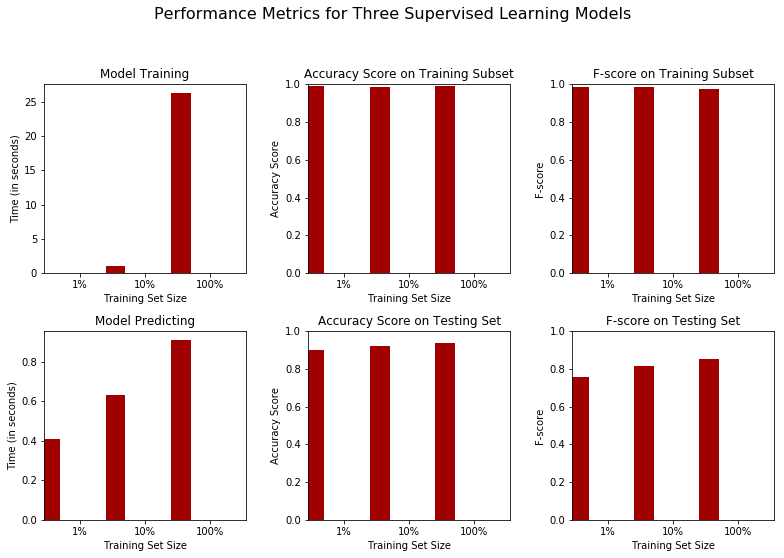

In [83]:
accuracy = None
fig, ax = pl.subplots(2, 3, figsize = (11,7))
bar_width = 0.3
colors = ['#A00000','#00A0A0','#00A000']
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
        for i in np.arange(3):

            # Creative plot code
            ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
            ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
            ax[j//3, j%3].set_xlabel("Training Set Size")
            ax[j//3, j%3].set_xlim((-0.1, 3.0))

# Add unique y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Accuracy Score")
ax[0, 2].set_ylabel("F-score")
ax[1, 0].set_ylabel("Time (in seconds)")
ax[1, 1].set_ylabel("Accuracy Score")
ax[1, 2].set_ylabel("F-score")

# Add titles
ax[0, 0].set_title("Model Training")
ax[0, 1].set_title("Accuracy Score on Training Subset")
ax[0, 2].set_title("F-score on Training Subset")
ax[1, 0].set_title("Model Predicting")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[1, 2].set_title("F-score on Testing Set")

# Set y-limits for score panels
ax[0, 1].set_ylim((0, 1))
ax[0, 2].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[1, 2].set_ylim((0, 1))


# Aesthetics
pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
pl.tight_layout()
pl.show()

# Part 4 Conslusion

Fascinating! We can see the results of our RandomForest Algorithm here within these visualizations. While I would like to draw conclusions here, I will be doing a write up blog Post on Medium, which will in depth document what I have accomplished here and what my concluding remarks are! Please visit it for my conclsion at: https://medium.com/@josephdantelarocca/random-forest-classification-on-small-business-loans-ecbd5ec7b415

I Would like to thank and Credit Udacity for this entire experience and for helping provide key visualization help in order to make this Notebook look as good as it does, thank you!